In [1]:
import os, sys
sys.path.append('..')

In [13]:
from mtools import read_file, join_path
import pandas as pd
from tools.tools import convert_AllSenosr_log
from scipy.spatial.transform import Rotation as R
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tools.tools import rerange_deg
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12.0, 3.0]

# allsenorfile = '../IGRData/IGR230510/origin/Mate30_2/23.05.06-12_26_08.csv'
# h5file = '../IGRProcessed/Mate30_2/23_05_06_12_26_04/data.h5'
# h5file = '../IGRData/IGR230510/processed/Mate30_2/23_05_06_12_26_04/data.h5'
# h5file = '../IGRData/IGR230510/processed/Mate30_2/23_05_06_12_36_43/data.h5'
# h5file = '../IGRData/IGR230510/processed/Nova9pro/23_05_06_18_42_34/data.h5'
h5file = '../IGRProcessed/Mi11/23_03_07_16_19_39/data.h5'

store = pd.HDFStore(h5file, mode='r')
gngga_df = store.get('gngga')
acc_df = store.get('acc')
ori_df = store.get('ori')
# rot_df = store.get('rot')
# game_df = store.get('gamerot')
mag_df = store.get('mag')
store.close()
freq = 100

<Axes: >

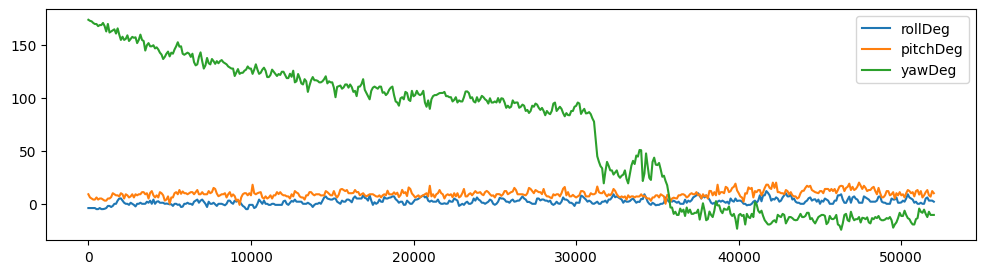

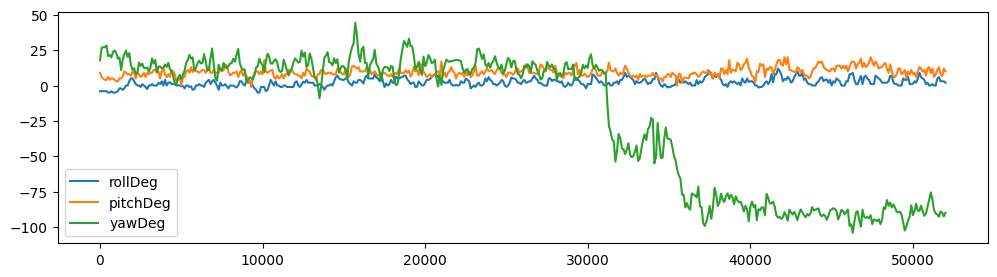

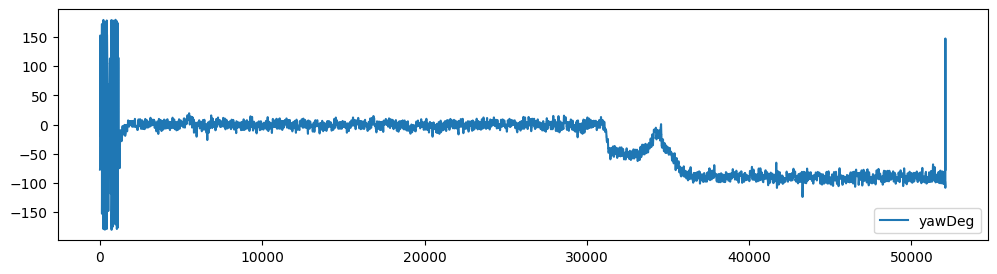

In [14]:
# game_df[::freq][['rollDeg', 'pitchDeg', 'yawDeg']].plot()
ori_df[::freq][['rollDeg', 'pitchDeg', 'yawDeg']].plot()
# rot_df[::freq][['rollDeg', 'pitchDeg', 'yawDeg']].plot()
mag_df[::freq][['rollDeg', 'pitchDeg', 'yawDeg']].plot()
gngga_df[['yawDeg']].plot()

[37.59613711  7.9535788  13.21204496  7.45182525]
[12.84363832  6.68597389  6.53198468  6.67919714]
[15.40540566  8.8495328   8.60458116  8.84364566]


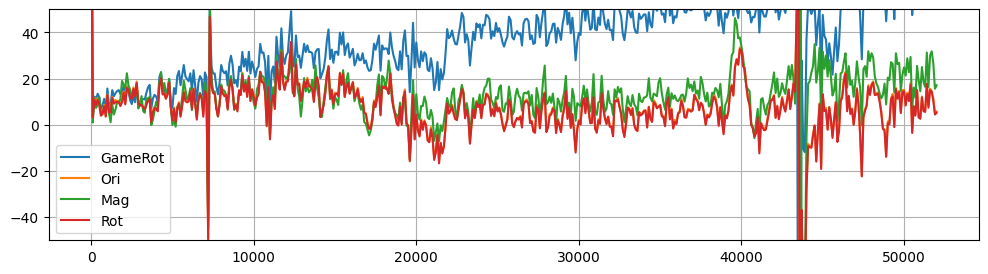

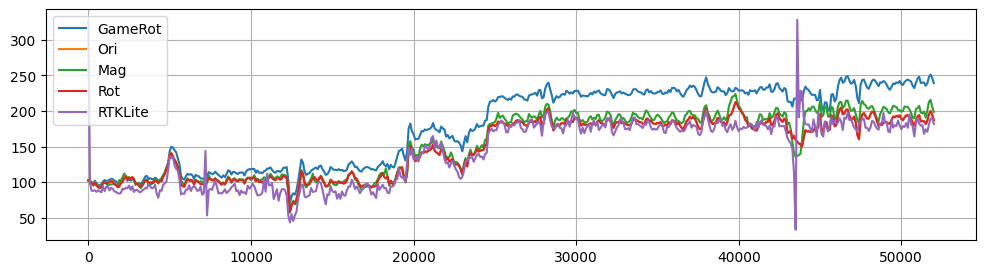

In [73]:
def rerange_deg(raw_deg):
    # raw_deg = gt_df[bearing_key].values
    raw_deg = raw_deg%360 # 所有角度限制到[0,360]
    raw_deg[raw_deg>180] = raw_deg[raw_deg>180]-360
    return raw_deg

yaws = np.column_stack((game_df['yawDeg'], ori_df['yawDeg'], mag_df['yawDeg'], rot_df['yawDeg'], gngga_df['yawDeg']))
yaws = rerange_deg(yaws)
yaws_diff = rerange_deg(yaws[:, :-1]-yaws[:, -1:])
yaws[yaws<0] = yaws[yaws<0] + 360
stable_mask = np.all(np.abs(yaws_diff[:, 1:])<50, axis=-1)

yaw_diff_df = pd.DataFrame(yaws_diff, columns=['GameRot', 'Ori', 'Mag', 'Rot'])
g = yaw_diff_df[::freq].plot()
g.grid()
g.set_ylim([-50, 50])

yaw_df = pd.DataFrame(yaws, columns=['GameRot', 'Ori', 'Mag', 'Rot', 'RTKLite'])
g = yaw_df[::freq].plot()
g.grid()

print(np.mean(yaws_diff[stable_mask], axis=0))
print(np.mean(np.abs(yaws_diff[stable_mask] - np.mean(yaws_diff[stable_mask], axis=0)), axis=0))
print(np.std(yaws_diff[stable_mask], axis=0))

In [46]:
from scipy import signal

def moving_average_filter(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

enu_pos = gngga_df[['PosE', 'PosN']].values
enu_pos[:, 0] = moving_average_filter(enu_pos[:, 0], 10)
enu_pos[:, 1] = moving_average_filter(enu_pos[:, 1], 10)
yaws = np.arctan2(enu_pos[1:, 1]-enu_pos[:-1, 1], enu_pos[1:, 0]-enu_pos[:-1, 0])*180/np.pi
gngga_df_new = gngga_df[1:]
gngga_df_new['yawDeg'] = yaws

euler = R.from_quat(rot_df[['quaternionX','quaternionY','quaternionZ','quaternionW']]).as_euler('xyz', degrees=True)
rot_df[['pitchDeg', 'rollDeg', 'yawDeg']] = euler
game_euler = R.from_quat(game_df[['quaternionX','quaternionY','quaternionZ','quaternionW']]).as_euler('xyz', degrees=True)
game_df[['pitchDeg', 'rollDeg', 'yawDeg']] = game_euler

/tmp/ipykernel_5883/3095051000.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gngga_df_new['yawDeg'] = yaws


In [ ]:
acc_df[::freq][['AccX', 'AccY', 'AccZ']].plot()